# Курсовой проект

Display name on kaggle: <b>Denis Kotelnikov</b>
<p>
Public score: <b>0.72386</b>

## Вспомогательные определения

In [64]:
import numpy as np
import pandas as pd
import random

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [65]:
def evaluate_preds(true_values, pred_values):
    print("Train R2:\t" + str(round(r2(true_values, pred_values), 3)));
    
    plt.figure(figsize=(18,10));
    
    sns.jointplot(x=pred_values, y=true_values);
    plt.xlabel('Predicted values');
    plt.ylabel('True values');
    plt.title('Prediction');
    
    plt.show();

## 1. Чистка данных (EDA)

После анализа данных в колонках будем создавать функции, которые можно будет вызвать на тестовом датасете, чтобы его почистить.

In [66]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [67]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [68]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [69]:
test_df = pd.read_csv(TEST_DATASET_PATH)
total_df = pd.concat([train_df, test_df], axis=0) #ignore_index=True)
#total_df.to_csv("total.csv", index=False)
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4999
Data columns (total 20 columns):
DistrictId       15000 non-null int64
Ecology_1        15000 non-null float64
Ecology_2        15000 non-null object
Ecology_3        15000 non-null object
Floor            15000 non-null int64
Healthcare_1     7825 non-null float64
Helthcare_2      15000 non-null int64
HouseFloor       15000 non-null float64
HouseYear        15000 non-null int64
Id               15000 non-null int64
KitchenSquare    15000 non-null float64
LifeSquare       11846 non-null float64
Price            10000 non-null float64
Rooms            15000 non-null float64
Shops_1          15000 non-null int64
Shops_2          15000 non-null object
Social_1         15000 non-null int64
Social_2         15000 non-null int64
Social_3         15000 non-null int64
Square           15000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 2.4+ MB


### 1.1 Разбираемся с пустыми ячейками (null) и object

LifeSquare и Healthcare_1 имеют много пустых ячеек. Для простоты выбросим обе эти колонки.

In [70]:
def handleNulls(df):
    df.drop('LifeSquare', axis=1, inplace=True)
    df.drop('Healthcare_1', axis=1, inplace=True)

handleNulls(train_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(6), int64(9), object(3)
memory usage: 1.4+ MB


In [71]:
def handleObjects(df):
    binary_to_numbers = {'A': 0, 'B': 1}
    df['Ecology_2'] = df['Ecology_2'].replace(binary_to_numbers)
    df['Ecology_3'] = df['Ecology_3'].replace(binary_to_numbers)
    df['Shops_2'] = df['Shops_2'].replace(binary_to_numbers)
    
handleObjects(train_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null int64
Ecology_3        10000 non-null int64
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null int64
Price            10000 non-null float64
dtypes: float64(6), int64(12)
memory usage: 1.4 MB


### 1.2 Выбросы

<b>KitchenSquare

In [72]:
train_df['KitchenSquare'].value_counts().sort_index()

0.0        697
1.0       2460
2.0          4
3.0         22
4.0         39
5.0       1169
6.0       1038
7.0        609
8.0       1306
9.0        843
10.0      1075
11.0       233
12.0       249
13.0        67
14.0        51
15.0        31
16.0        16
17.0        12
18.0         6
19.0        11
20.0        14
21.0         1
22.0         3
23.0         1
25.0         2
26.0         1
27.0         1
29.0         1
30.0         2
31.0         1
32.0         2
35.0         1
36.0         1
37.0         2
39.0         1
40.0         1
41.0         2
42.0         1
43.0         2
48.0         1
51.0         2
53.0         1
54.0         1
58.0         2
60.0         1
62.0         1
63.0         1
66.0         1
72.0         1
73.0         1
75.0         1
78.0         1
84.0         1
96.0         1
112.0        2
123.0        1
1970.0       1
2014.0       1
Name: KitchenSquare, dtype: int64

In [73]:
def cleanKitchenSquare(df):
    df.loc[df['KitchenSquare'] < 4, 'KitchenSquare'] = 4
    df.loc[df['KitchenSquare'] > 20, 'KitchenSquare'] = 20

cleanKitchenSquare(train_df)
train_df['KitchenSquare'].value_counts().sort_index()

4.0     3222
5.0     1169
6.0     1038
7.0      609
8.0     1306
9.0      843
10.0    1075
11.0     233
12.0     249
13.0      67
14.0      51
15.0      31
16.0      16
17.0      12
18.0       6
19.0      11
20.0      62
Name: KitchenSquare, dtype: int64

<b>Floor

In [74]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor'].count()

1825

In [75]:
total_df['HouseFloor'].describe()

count    15000.000000
mean        12.606600
std          6.780165
min          0.000000
25%          9.000000
50%         12.000000
75%         17.000000
max        117.000000
Name: HouseFloor, dtype: float64

In [76]:
train_df.query('Floor > HouseFloor').head()

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,4.0,14,0.0,1977,0.075779,1,1,6,1437,3,0,2,1,221244.156664
14,10953,27,1.0,53.769097,4.0,5,4.0,1977,0.072158,1,1,2,629,1,0,0,0,140647.565937
16,2119,27,2.0,49.360648,5.0,6,5.0,1983,0.051815,1,1,5,1227,0,0,0,1,117000.381287
21,11935,27,2.0,64.711835,4.0,15,1.0,1977,0.211401,1,1,9,1892,0,0,1,1,127200.026511
23,6641,54,3.0,118.907612,4.0,2,0.0,1977,0.006076,1,1,30,5285,0,6,6,1,571069.052600


In [77]:
def cleanFloor(df):
    df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = total_df['HouseFloor'].median()
    aboveLastFloor = (df['Floor'] > df['HouseFloor']) 
    df.loc[aboveLastFloor, 'Floor'] = df.loc[aboveLastFloor, 'HouseFloor']
    
cleanFloor(train_df)

In [78]:
train_df.query('Floor > HouseFloor')

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price


<b>HouseYear

In [79]:
total_df.query("HouseYear>2020")

,DistrictId,Ecology_1,Ecology_2,Ecology_3,Floor,Healthcare_1,Helthcare_2,HouseFloor,HouseYear,Id,KitchenSquare,LifeSquare,Price,Rooms,Shops_1,Shops_2,Social_1,Social_2,Social_3,Square
1497,109,0.136330,B,B,9,262.0,3,12.0,20052011,10814,9.0,20.239714,254084.534396,1.0,6,B,30,6141,10,37.265070
4189,147,0.319809,B,B,4,2857.0,5,9.0,4968,11607,5.0,28.360393,243028.603096,2.0,8,B,25,4756,16,44.791836


In [80]:
def cleanHouseYear(df):
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
    
cleanHouseYear(train_df)
train_df.query("HouseYear>2020")

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price


## 2. Построение модели

In [81]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

target_name = 'Price'

In [82]:
X = train_df[feature_names]
y = train_df[target_name]

In [83]:
X.head()

,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2
0,35,2.0,47.981561,6.0,7.0,9.0,1969,0.089040,1,1,33,7976,5,0,11,1
1,41,3.0,65.683640,8.0,7.0,9.0,1978,0.000070,1,1,46,10309,1,1,16,1
2,53,2.0,44.947953,4.0,8.0,12.0,1968,0.049637,1,1,34,7759,0,1,3,1
3,58,2.0,53.352981,9.0,8.0,17.0,1977,0.437885,1,1,23,5735,3,0,5,1
4,99,1.0,39.649192,7.0,11.0,12.0,1976,0.012339,1,1,35,5776,1,2,4,1


In [84]:
y.head()

0    184966.930730
1    300009.450063
2    220925.908524
3    175616.227217
4    150226.531644
Name: Price, dtype: float64

### Попробуем линейную регрессию

In [85]:
lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

Train R2:	0.495


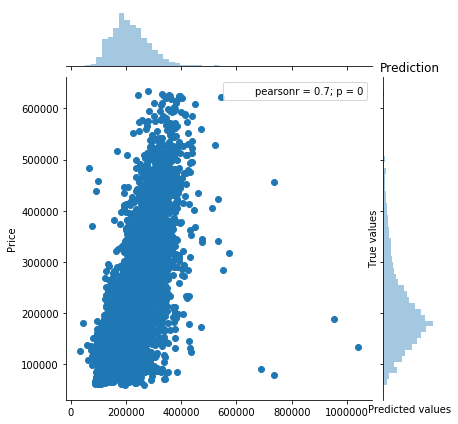

In [86]:
evaluate_preds(y, y_pred)

### Теперь попробуем случайный лес

In [87]:
rf = RandomForestRegressor(random_state=21, criterion='mse')
rf.fit(X, y)
y_pred = rf.predict(X)

Train R2:	0.947


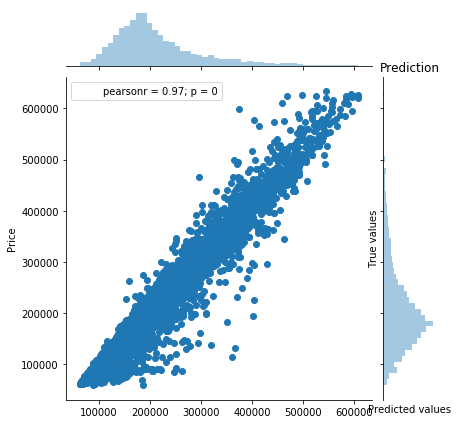

In [88]:
evaluate_preds(y, y_pred)

In [89]:
importance = pd.DataFrame({'feature':X.columns.get_values(), 'importance':rf.feature_importances_})
importance.sort_values(by='importance', ascending=False,inplace=True)
importance

,feature,importance
2,Square,0.397398
11,Social_2,0.103855
1,Rooms,0.086352
10,Social_1,0.086257
12,Social_3,0.058632
0,DistrictId,0.053995
6,HouseYear,0.045324
7,Ecology_1,0.043867
4,Floor,0.030902
3,KitchenSquare,0.028775


## 2. Предсказание для kaggle на тестовом датасете

In [90]:
handleNulls(test_df)
handleObjects(test_df)
cleanKitchenSquare(test_df)
cleanFloor(test_df)
cleanHouseYear(test_df)

X_test = test_df[feature_names]
y_pred_test = rf.predict(X_test)

In [91]:
submit = pd.read_csv('sample_submission.csv')


In [92]:
submit['Price'] = y_pred_test


In [93]:
submit.to_csv('submission.csv', index=False)